<a href="https://colab.research.google.com/github/jmorrison150/HousePricesDownload/blob/master/Clusters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from pandas import read_table
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

URL = "https://raw.githubusercontent.com/jmorrison150/HousePricesDownload/master/cleanData/propertyValue-Dallas4.csv"


try:
    # [OPTIONAL] Seaborn makes plots nicer
    import seaborn
except ImportError:
    pass


In [0]:
def download_data():
    '''
    Downloads the data for this script into a pandas DataFrame.
    '''

    # If your data is in an Excel file, install 'xlrd' and use
    # pandas.read_excel instead of read_table
    #from pandas import read_excel
    #frame = read_excel(URL)

    # If your data is in a private Azure blob, install 'azure-storage' and use
    # BlockBlobService.get_blob_to_path() with read_table() or read_excel()
    #from azure.storage.blob import BlockBlobService
    #service = BlockBlobService(ACCOUNT_NAME, ACCOUNT_KEY)
    #service.get_blob_to_path(container_name, blob_name, 'my_data.csv')
    #frame = read_table('my_data.csv', ...

    frame = read_table(
        URL,
        
        # Uncomment if the file needs to be decompressed
        #compression='gzip',
        #compression='bz2',

        # Specify the file encoding
        # Latin-1 is common for data from US sources
        #encoding='latin-1',
        encoding='utf-8',  # UTF-8 is also common

        # Specify the separator in the data
        sep=',',            # comma separated values
        #sep='\t',          # tab separated values
        #sep=' ',           # space separated values

        # Ignore spaces after the separator
        skipinitialspace=True,

        # Treat question marks as missing values
        na_values=['?'],

        # Generate row labels from each row number
        index_col=None,
        #index_col=0,       # use the first column as row labels
        #index_col=-1,      # use the last column as row labels

        # Generate column headers row from each column number
        #header=None,
        header=0,          # use the first line as headers

        # Use manual headers and skip the first row in the file
        #header=0,
        #names=['col1', 'col2', ...],
    )

    # Return a subset of the columns
    #return frame[['col1', 'col4', ...]]

    # Return the entire frame
    #return frame

    # Return all except the first column
    del frame[frame.columns[0]]
    return frame


In [0]:

def get_features(frame):
    '''
    Transforms and scales the input data and returns a numpy array that
    is suitable for use with scikit-learn.

    Note that in unsupervised learning there are no labels.
    '''

    # Replace missing values with 0.0
    # or we can use scikit-learn to calculate missing values below
    #frame[frame.isnull()] = 0.0

    # Convert values to floats
    arr = np.array(frame, dtype=np.float)

    # Impute missing values from the mean of their entire column
    from sklearn.preprocessing import Imputer
    imputer = Imputer(strategy='mean')
    arr = imputer.fit_transform(arr)
    
    # Normalize the entire data set to mean=0.0 and variance=1.0
    from sklearn.preprocessing import scale
    arr = scale(arr)

    return arr



In [0]:
def reduce_dimensions(X):
    '''
    Reduce the dimensionality of X with different reducers.

    Return a sequence of tuples containing:
        (title, x coordinates, y coordinates)
    for each reducer.
    '''

    # Principal Component Analysis (PCA) is a linear reduction model
    # that identifies the components of the data with the largest
    # variance.
    from sklearn.decomposition import PCA
    reducer = PCA(n_components=2)
    X_r = reducer.fit_transform(X)
    yield 'PCA', X_r[:, 0], X_r[:, 1]

    # Independent Component Analysis (ICA) decomposes a signal by
    # identifying the independent contributing sources.
    from sklearn.decomposition import FastICA
    reducer = FastICA(n_components=2)
    X_r = reducer.fit_transform(X)
    yield 'ICA', X_r[:, 0], X_r[:, 1]

    # t-distributed Stochastic Neighbor Embedding (t-SNE) is a
    # non-linear reduction model. It operates best on data with a low
    # number of attributes (<50) and is often preceded by a linear
    # reduction model such as PCA.
    from sklearn.manifold import TSNE
    reducer = TSNE(n_components=2)
    X_r = reducer.fit_transform(X)
    yield 't-SNE', X_r[:, 0], X_r[:, 1]


In [0]:
def evaluate_learners(X):
    '''
    Run multiple times with different learners to get an idea of the
    relative performance of each configuration.

    Returns a sequence of tuples containing:
        (title, predicted classes)
    for each learner.
    '''

    from sklearn.cluster import (MeanShift, MiniBatchKMeans,
                                 SpectralClustering, AgglomerativeClustering)

    learner = MeanShift(
        # Let the learner use its own heuristic for determining the
        # number of clusters to create
        bandwidth=None
    )
    y = learner.fit_predict(X)
    yield 'Mean Shift clusters', y

    learner = MiniBatchKMeans(n_clusters=2)
    y = learner.fit_predict(X)
    yield 'K Means clusters', y

    learner = SpectralClustering(n_clusters=2)
    y = learner.fit_predict(X)
    yield 'Spectral clusters', y

    learner = AgglomerativeClustering(n_clusters=2)
    y = learner.fit_predict(X)
    yield 'Agglomerative clusters (N=2)', y

    learner = AgglomerativeClustering(n_clusters=5)
    y = learner.fit_predict(X)
    yield 'Agglomerative clusters (N=5)', y


In [0]:
def plot(Xs, predictions):
    '''
    Create a plot comparing multiple learners.

    `Xs` is a list of tuples containing:
        (title, x coord, y coord)
    
    `predictions` is a list of tuples containing
        (title, predicted classes)

    All the elements will be plotted against each other in a
    two-dimensional grid.
    '''

    # We will use subplots to display the results in a grid
    nrows = len(Xs)
    ncols = len(predictions)

    fig = plt.figure(figsize=(16, 8))
    fig.canvas.set_window_title('Clustering data from ' + URL)

    # Show each element in the plots returned from plt.subplots()
    
    for row, (row_label, X_x, X_y) in enumerate(Xs):
        for col, (col_label, y_pred) in enumerate(predictions):
            ax = plt.subplot(nrows, ncols, row * ncols + col + 1)
            if row == 0:
                plt.title(col_label)
            if col == 0:
                plt.ylabel(row_label)

            # Plot the decomposed input data and use the predicted
            # cluster index as the value in a color map.
            plt.scatter(X_x, X_y, c=y_pred.astype(np.float), cmap='prism', alpha=0.5)
            
            # Set the axis tick formatter to reduce the number of ticks
            ax.xaxis.set_major_locator(MaxNLocator(nbins=4))
            ax.yaxis.set_major_locator(MaxNLocator(nbins=4))

    # Let matplotlib handle the subplot layout
    plt.tight_layout()

    # ==================================
    # Display the plot in interactive UI
    plt.show()

    # To save the plot to an image file, use savefig()
    #plt.savefig('plot.png')

    # Open the image file with the default image viewer
    #import subprocess
    #subprocess.Popen('plot.png', shell=True)

    # To save the plot to an image in memory, use BytesIO and savefig()
    # This can then be written to any stream-like object, such as a
    # file or HTTP response.
    #from io import BytesIO
    #img_stream = BytesIO()
    #plt.savefig(img_stream, fmt='png')
    #img_bytes = img_stream.getvalue()
    #print('Image is {} bytes - {!r}'.format(len(img_bytes), img_bytes[:8] + b'...'))

    # Closing the figure allows matplotlib to release the memory used.
    plt.close()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: FutureWarning: read_table is deprecated, use read_csv instead.


Processing 720 samples with 7 attributes
Reducing dimensionality


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/fastica_.py:314: RuntimeWarning: divide by zero encountered in true_divide
  K = (u / d).T[:n_components]  # see (6.33) p.140
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/fastica_.py:314: RuntimeWarning: invalid value encountered in true_divide
  K = (u / d).T[:n_components]  # see (6.33) p.140


Evaluating clustering learners
Plotting the results


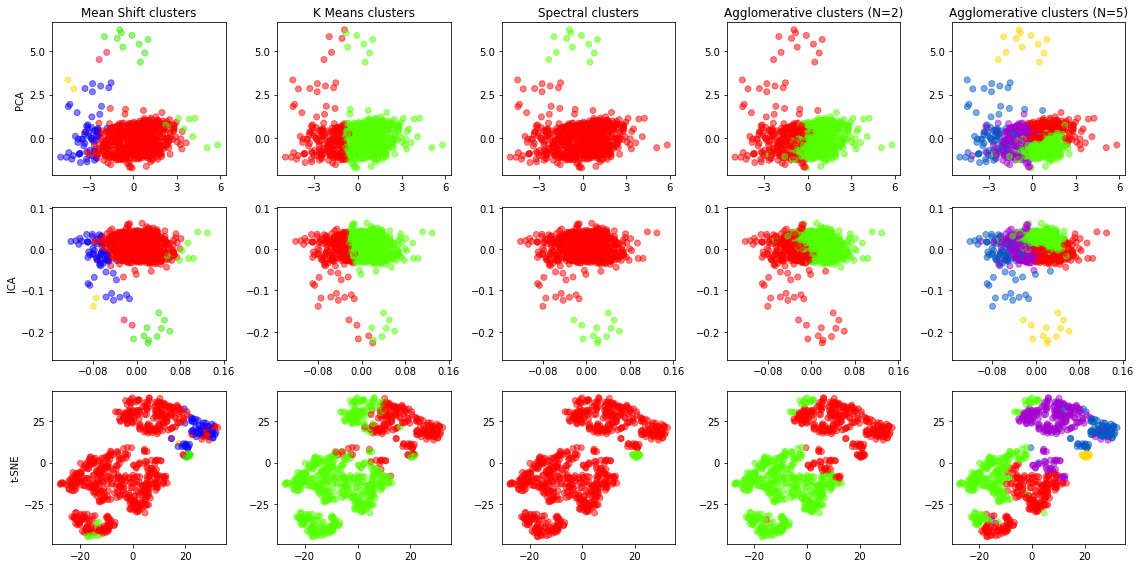

In [7]:
if __name__ == '__main__':
    # Download the data set from URL
    print("Downloading data from {}".format(URL))
    frame = download_data()

    # Process data into a feature array
    # This is unsupervised learning, and so there are no labels
    print("Processing {} samples with {} attributes".format(len(frame.index), len(frame.columns)))
    X = get_features(frame)

    # Run multiple dimensionality reduction algorithms on the data
    print("Reducing dimensionality")
    Xs = list(reduce_dimensions(X))

    # Evaluate multiple clustering learners on the data
    print("Evaluating clustering learners")
    predictions = list(evaluate_learners(X))

    # Display the results
    print("Plotting the results")
    plot(Xs, predictions)
